In [1]:
import os, urllib
import numpy as np
import seaborn as sb
import datetime
from multiprocessing import Process, Queue

import pandas as pd
import IPython
from skimage.measure import label

from NegotiationConfig import *
from SegmentationModel import SegmentationModel
from NegotiationTools import NegotiationTools
from NegotiationTools import plot


In [2]:
# Select which models to use
MODEL_EPOCH = 1

# Combining Segmentation models using Cooperative Negotiation

## Agents and Mediator definition

In [3]:
class Agent():
    def __init__(self, agentname, model, alpha_fun):
        self.agentname=agentname
        self.model=model
        self.task = None
        self.initial_proposal = None
        self.alpha_fun = alpha_fun
        self.alpha = None
        
    def new_task(self, image):
        self.task = image
        self.initial_proposal = self.model.predict(image).numpy()[0]
        #logits=logits[:self.task.size[1], :self.task.size[0], ...] # Otherwise logits are a square matrix [when using DeepLab]
        #self.initial_proposal = softmax(logits, axis=-1)
        self.last_proposal = self.initial_proposal
        self.alpha = self.alpha_fun(self.initial_proposal)
        return self.initial_proposal
    
    def propose(self, agreement):
        self.last_agreement = agreement
        self.last_proposal = self.last_proposal + self.alpha*(agreement - self.last_proposal)
        
        return self.last_proposal
    

In [4]:
class Mediator():
    def __init__(self, agents):
        self.agents = agents
        self.last_step=0
        self.W = None
        self.tools = NegotiationTools()
        
    def start_new_task(self, image):
        self.last_step=0
        self.task = image
        self.initial_proposals = np.array([agent.new_task(self.task) for agent in self.agents])
        self.last_proposals = self.initial_proposals
        self.W = np.ones_like(self.initial_proposals)
        
        return self.last_proposals

        
    def negotiation(self, task, timeout = 500):
        for i in range(self.last_step, self.last_step+timeout):
            if i==0:
                self.last_proposals = self.start_new_task(task)
                # self.agent_queues = [Queue() for a in self.agents]
                # self.agent_processes = [(self.agent_queues[a], Process(target=self.agents[a].propose, args=(self.agent_queues[a],))) for a in range(len(self.agents))]
            else:
                # Propose the new agreement to the agents
                
                self.last_proposals = np.array([agent.propose(self.last_agreement) for agent in self.agents]) # ((p0, u0), (p1, u1), ...)
                
                    
            self.last_step = i            
            self.last_agreement = np.divide(np.sum(self.last_proposals*self.W, axis=0), np.sum(self.W, axis=0))

            if self.tools.get_consensus(self.last_proposals).all():
                yield 'consensus', self.last_agreement, self.last_proposals
                raise StopIteration()
            else:
                yield 'negotiation', self.last_agreement, self.last_proposals
        yield 'timeout', self.last_agreement, self.last_proposals
        raise StopIteration()

### Loading Deep Learning Models

In [5]:
# Creating the models
models = {AGENT_NAMES[i]: SegmentationModel(ALL_LABELS[i]) for i in range(len(AGENT_NAMES))}
# Load the checkpoints
for l, m in models.items():
    m.load_finetuned_network(epoch=MODEL_EPOCH)

W0924 15:24:18.761690 139929730922240 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Loaded model for label bird at epoch 1


W0924 15:24:21.966277 139929730922240 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Loaded model for label dog at epoch 1


W0924 15:24:25.116650 139929730922240 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Loaded model for label horse at epoch 1


W0924 15:24:28.303068 139929730922240 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Loaded model for label cat at epoch 1


## Strategy Definitions

In [6]:
def alpha_funcs_ep():
    '''Definitions of the alpha_fun for each model. An alpha_fun takes the last proposal as input and outputs a value alpha for each pixel'''
    def entropy_over_pixels(last_proposal):
        n_labels = last_proposal.shape[-1]
        entr = lambda x, base=n_labels, eps=10e-16: -np.sum(x*np.log(x+eps)/np.log(base),axis=-1)
        entr_over_pixels = entr(last_proposal)
        return np.expand_dims(entr_over_pixels, axis=-1)
    return {modelname: entropy_over_pixels for modelname in models.keys()}

def alpha_funcs_ei():
    '''Definitions of the alpha_fun for each model. An alpha_fun takes the last proposal as input and outputs a value alpha for each pixel'''
    from scipy.stats import entropy
    def entropy_over_image(last_proposal):
        n_labels = last_proposal.shape[-1]
        entr = lambda x, base=n_labels, eps=10e-16: -np.sum(x*np.log(x+eps)/np.log(base),axis=-1)
        entr_over_pixels = entr(last_proposal)
        return np.mean(entr_over_pixels)   
    return {model_name: entropy_over_image for model_name in models.keys()}


In [7]:
# Instancing agents and mediators

result_logger = NegotiationTools()


alpha_ep = alpha_funcs_ep()
alpha_ei = alpha_funcs_ei()

METHODS = ['entropy_pixel', 'entropy_image']
STEPS = 100
DATASET = 'datasets/coco_animals_test_balanced.csv'
for i, (png_path, seg_path, input_sample, ground_truth) in enumerate(SegmentationModel('dummy').load_test_dataset(DATASET, batch_size=1)):
    
    agents_ep = [Agent(modelname, models[modelname], alpha_ep[modelname]) for modelname in AGENT_NAMES]
    mediator_ep = Mediator(agents_ep)
    agents_ei = [Agent(modelname, models[modelname], alpha_ei[modelname]) for modelname in AGENT_NAMES]
    mediator_ei = Mediator(agents_ei)
    
    
    ground_truth_np = ground_truth.numpy()
    png_path_str = png_path.numpy().astype(np.str).item()
    seg_path_str = seg_path.numpy().astype(np.str).item()
        
    # EP

    next_step_ep = enumerate(mediator_ep.negotiation(input_sample, timeout=STEPS))
    for step, (status, curr_agreement, curr_proposals) in next_step_ep:
        result_logger.log_step(sample=i, png_path=png_path_str, seg_path=seg_path_str, step=step, method='entropy_pixel', status=status, agreement=curr_agreement, proposals=curr_proposals, ground_truth=ground_truth_np, max_steps=STEPS)
        print("\rRunning: Sample: {}, Step: {}, Method: {}".format(i, step, 'ep'), end='')
        break
    break
    # EI

    next_step_ei = enumerate(mediator_ei.negotiation(input_sample, timeout=STEPS))
    for step, (status, curr_agreement, curr_proposals) in next_step_ei:
        result_logger.log_step(sample=i, png_path=png_path_str, seg_path=seg_path_str, step=step, method='entropy_image', status=status, agreement=curr_agreement, proposals=curr_proposals, ground_truth=ground_truth_np, max_steps=STEPS)
        print("\rRunning: Sample: {}, Step: {}, Method: {}".format(i, step, 'ei'), end='')
    
    if i % 10 ==1:
        result_logger.save()

result_logger.save()

Running: Sample: 0, Step: 0, Method: ep

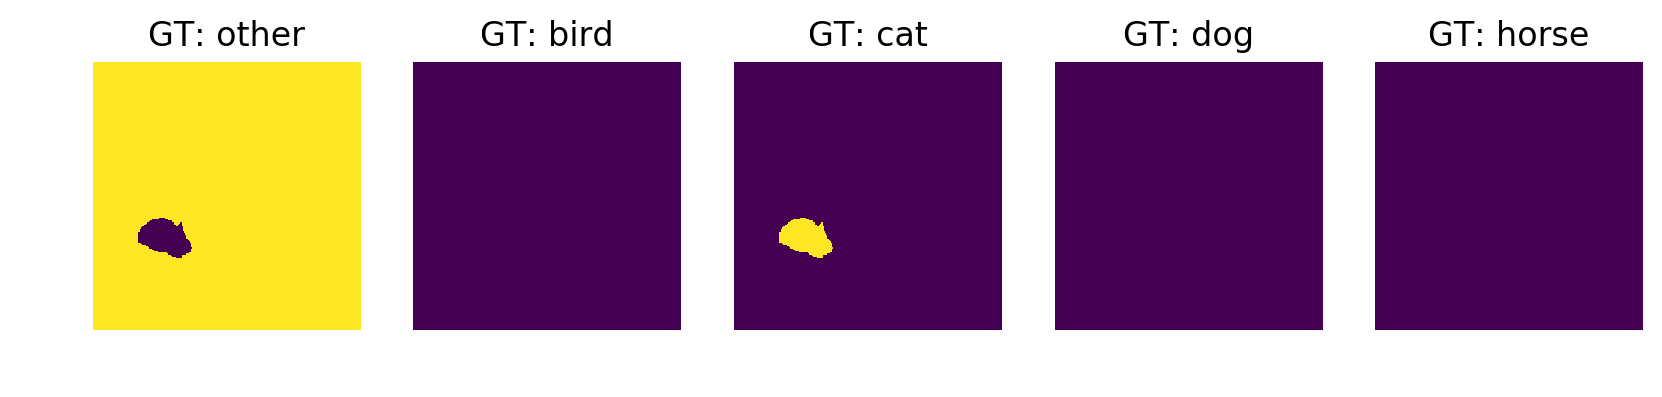

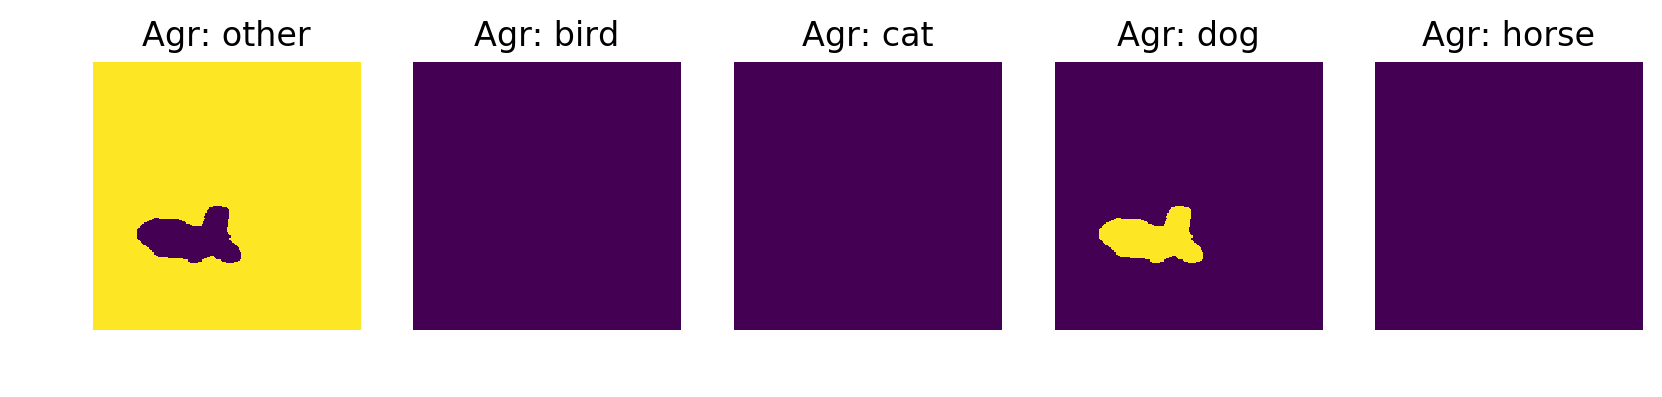

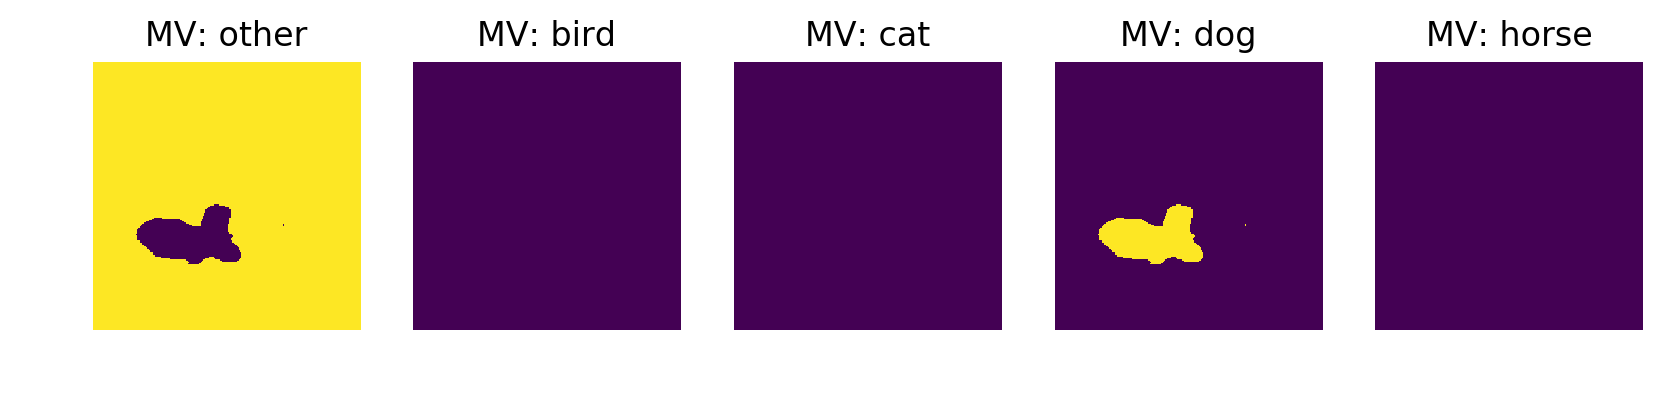

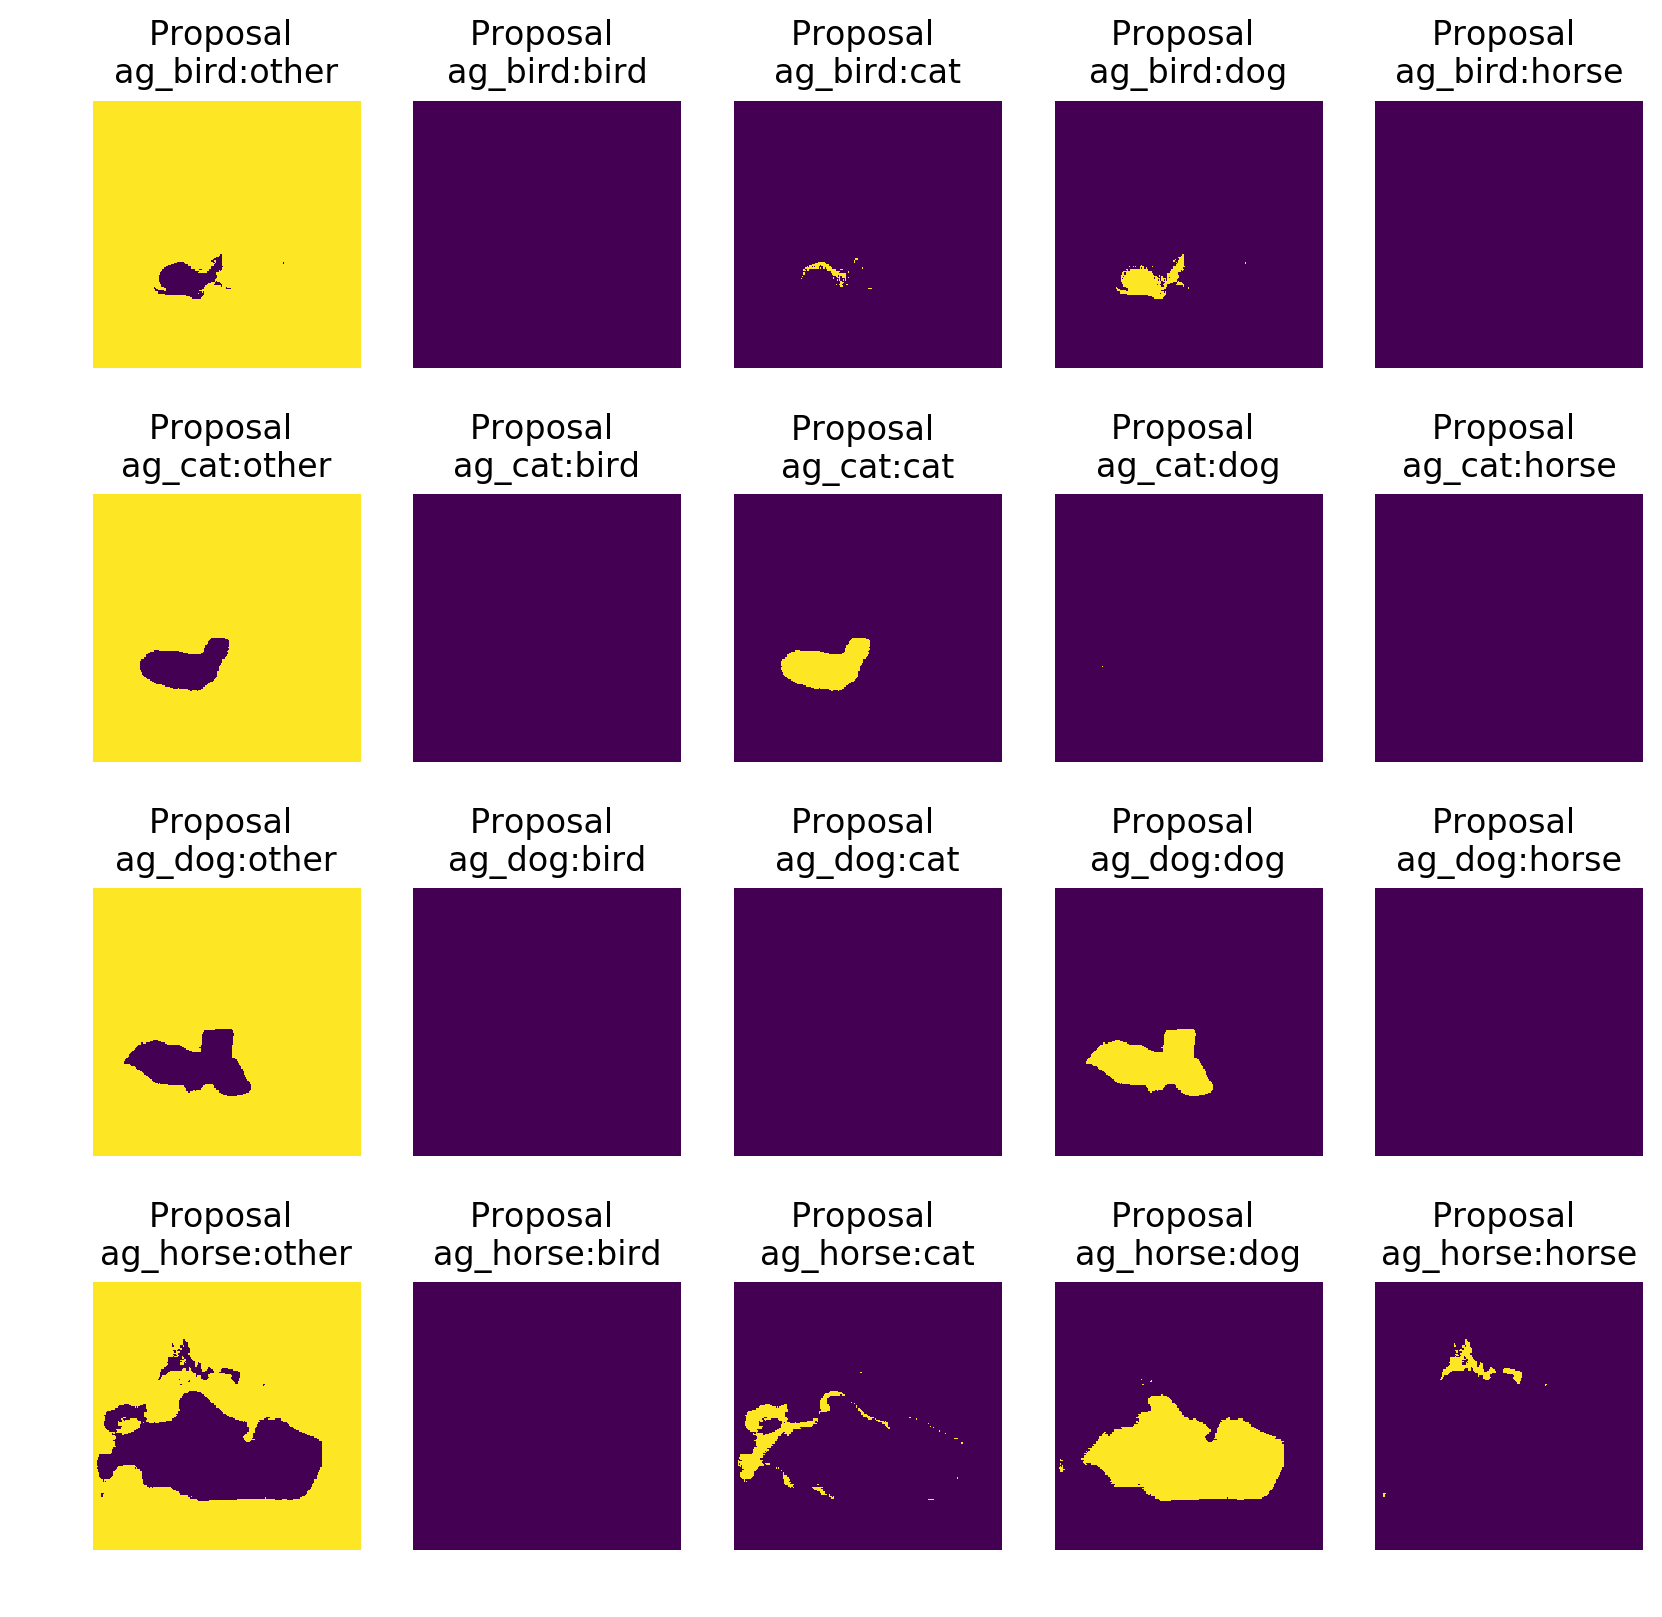

In [16]:
plot(majority=result_logger.majority, 
     agreement=np.equal(curr_agreement, curr_agreement.max(axis=-1)[...,np.newaxis]), 
     ground_truth=ground_truth_np[0],
     proposals=np.equal(curr_proposals, curr_proposals.max(axis=3)[...,np.newaxis]))


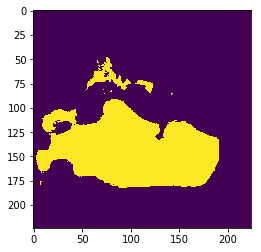

In [15]:
import matplotlib.pyplot as plt
plt.imshow(result_logger.consensus_mask)

In [21]:
result_logger.consensus_mask.shape

(224, 224)

In [26]:
random_masked = np.ma.masked_array(data=result_logger.consensus_mask, mask=np.random.rand(224, 224)>0.5)

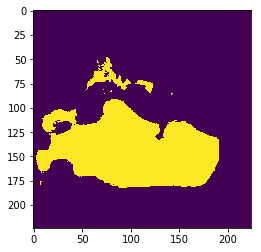

In [29]:
plt.imshow(random_masked.data)

In [ ]:
masked_proposals = np.ma.masked_array()
np.tile(result_logger.consensus_mask[np.newaxis, ..., np.newaxis], 
        (curr_proposals.shape[0], 1, 1, curr_proposals.shape[-1]))